### 產生特徵向量函式庫 copy from notebook 1


In [40]:
import numpy as np
import cv2
import math
from scipy import ndimage
from matplotlib import pyplot as plt
import pandas as pd


isPlot=False
idDebug=False
STEP=1 #每次多少角度
granularity=int(180/STEP)

def imgWrapA(orgImg,a):
    img_a = ndimage.rotate(orgImg, a, reshape=False)    
    return img_a
        
def test_gen(a, x,y,wh):
    bigMap="img/map_2d.png"
    orgImg = cv2.cvtColor(cv2.imread(bigMap), cv2.COLOR_BGR2RGB)
    #print('orgImg shape=',orgImg.shape)

    #Question

    orgImg_crop128=orgImg[y-wh: y + wh, x-wh: x + wh ]
    if isPlot: plt.imshow(orgImg_crop128)
    orgImg_crop128_a33=imgWrapA(orgImg_crop128,a)
    #print('imgWrapA shape=',orgImg_crop128_a33.shape)
    orgImg_crop128_a33_crop=orgImg_crop128_a33[int(wh/4): int(3*wh/4), int(wh/4): int(3*wh/4)]

    return orgImg_crop128_a33_crop



def sizeStatistic(img, type=0):
    bigger=img>127
    #print(bigger)
    #print(bigger.shape)
    bigger_tmp=bigger[0:26,6:26]
    bigger_tmp_2=bigger[0:26,7:27]
    sizeStatistic_result=np.zeros(8)
    for i in range(6):
        if type==0:
            bigger_tmp=np.logical_and(bigger_tmp ,bigger[i:26+i,6:26])
        elif type==1:
            bigger_tmp=np.logical_and(bigger_tmp ,bigger[0:26,6+i:26+i])
        elif type==2:
            bigger_tmp=np.logical_and(bigger_tmp ,bigger[0+i:26+i,6+i:26+i])
            bigger_tmp_2=np.logical_and(bigger_tmp_2 ,bigger[0+i:26+i,7+i:27+i])
        elif type==3:
            bigger_tmp=np.logical_and(bigger_tmp ,bigger[0+i:26+i,6-i:26-i])
            bigger_tmp_2=np.logical_and(bigger_tmp_2 ,bigger[0+i:26+i,7-i:27-i])

        sizeStatistic_result[i]=sum(sum(bigger_tmp))
        if type in [2,3]:  sizeStatistic_result[i] += sum(sum(bigger_tmp_2))
        if sizeStatistic_result[i]==0: break
    return sizeStatistic_result

def getFeature(sizeStatisticResult):
    s_result_diff=np.abs(np.diff(sizeStatisticResult[0:7]))
    s_result_diff_norm=s_result_diff/sum(s_result_diff)
    s_result_all=s_result_diff_norm#計算差值 加上normilize
    s_result_all=s_result_all+1 #避免出現 1, 準備log
    s_result_all=np.log(s_result_all)#log
    s_result_all=np.around(s_result_all, decimals=4)
    return s_result_all

#由圖檔得特徵向量，未知旋轉角度，應用時候可採用   
def getFeatures(monoImg):
    Features=np.zeros(24)
    for i in range(4):
        sizeStatisticResult=sizeStatistic(monoImg, i) 
        #print(i,sizeStatisticResult)
        Features[i*6:6+i*6]=getFeature(sizeStatisticResult)
    return Features

def getYandFeatures(a, monoImg):
    s_result_all=np.zeros(1+24)
    s_result_all[0]=a
    s_result_all[1:25]=getFeatures(monoImg)
    return s_result_all

#給定座標及轉角 可以得到一個特徵向量    
def genFeatureVector(a,x,y):
    challenge=test_gen(a,x,y,64);
    s_result_all=getYandFeatures(a, challenge[:,:,2])

    return s_result_all



### 生成測試數據及特徵向量

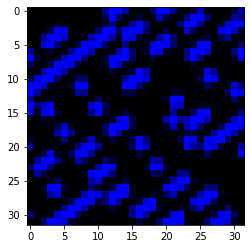

In [41]:
a=36
x=210
y=150

challenge=test_gen(a,x,y,64)
plt.imshow(challenge)

In [42]:
s_result_all=getFeatures(challenge[:,:,2])

print(s_result_all)
X_test_sin=s_result_all[[13,14,15,16,17,19,20,21,22,23]]
print(X_test_sin)
X_test_cos=s_result_all[[1,2,3,4,5,7,8,9,10,11]]
print(X_test_cos)

[0.3978 0.3397 0.0876 0.0076 0.0076 0.     0.3505 0.3122 0.1354 0.0448
 0.0076 0.0152 0.5499 0.2306 0.0075 0.     0.     0.     0.3903 0.2542
 0.1531 0.0149 0.0075 0.0441]
[0.2306 0.0075 0.     0.     0.     0.2542 0.1531 0.0149 0.0075 0.0441]
[0.3397 0.0876 0.0076 0.0076 0.     0.3122 0.1354 0.0448 0.0076 0.0152]


### 載入模型

In [43]:
import pickle

# load the trained decision tree classifier from Pickle
decision_tree_pkl_filename1 = 'decision_tree_1.pkl'
# Open the file to load as pkl file
with open(file=decision_tree_pkl_filename1, mode='rb') as f:
    regr1=pickle.load(f)
2# load the trained decision tree classifier from Pickle
decision_tree_pkl_filename2 = 'decision_tree_2.pkl'
# Open the file to load as pkl file
with open(file=decision_tree_pkl_filename2, mode='rb') as f:
    regr2=pickle.load(f)


### 測試

In [44]:


regr_y_result1 = regr1.predict(X_test_cos.reshape(1, -1))
regr_y_result2 = regr2.predict(X_test_sin.reshape(1, -1))

print(regr_y_result1)
print(regr_y_result2)


[0.33109478]
[0.91490084]


In [45]:

theta=np.arctan2(regr_y_result2,regr_y_result1)*90/np.pi
theta=theta[0]
print(theta)


35.05262181347546


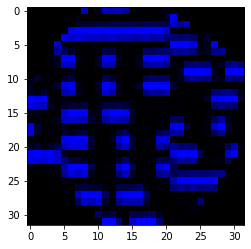

In [46]:
correct_challenge=imgWrapA(challenge,-theta)
plt.imshow(correct_challenge)